<a href="https://colab.research.google.com/github/cytrus2012/bachelorthesis/blob/main/antcolony.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration 0, Best Score: 11320.411270683866
Iteration 1, Best Score: 10905.325496416894
Iteration 2, Best Score: 11180.225539113291
Iteration 3, Best Score: 11630.95840489713
Iteration 4, Best Score: 11021.803805933674
Iteration 5, Best Score: 11021.80380593367
Iteration 6, Best Score: 10589.65423867496
Iteration 7, Best Score: 10589.65423867496
Iteration 8, Best Score: 10589.65423867496
Iteration 9, Best Score: 10589.65423867496
Iteration 10, Best Score: 10589.65423867496
Iteration 11, Best Score: 10589.65423867496
Iteration 12, Best Score: 10589.65423867496
Iteration 13, Best Score: 10589.65423867496
Iteration 14, Best Score: 10589.65423867496
Iteration 15, Best Score: 10589.65423867496
Iteration 16, Best Score: 10589.65423867496
Stopping early after 10 stagnant iterations.
Best path score: 10589.65423867496
Best path: [8, 5, 0, 2, 4, 1, 3, 7, 9, 6, 8]


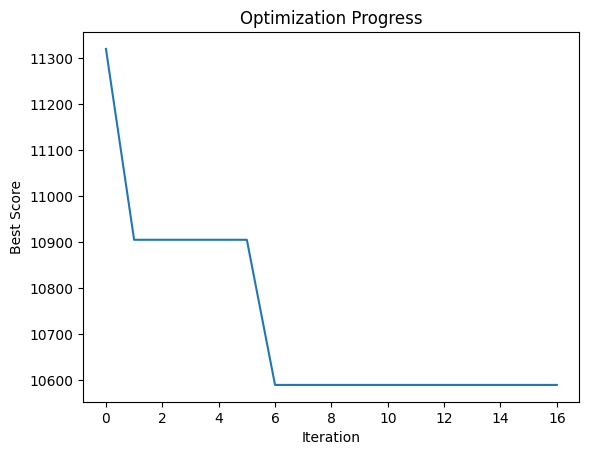

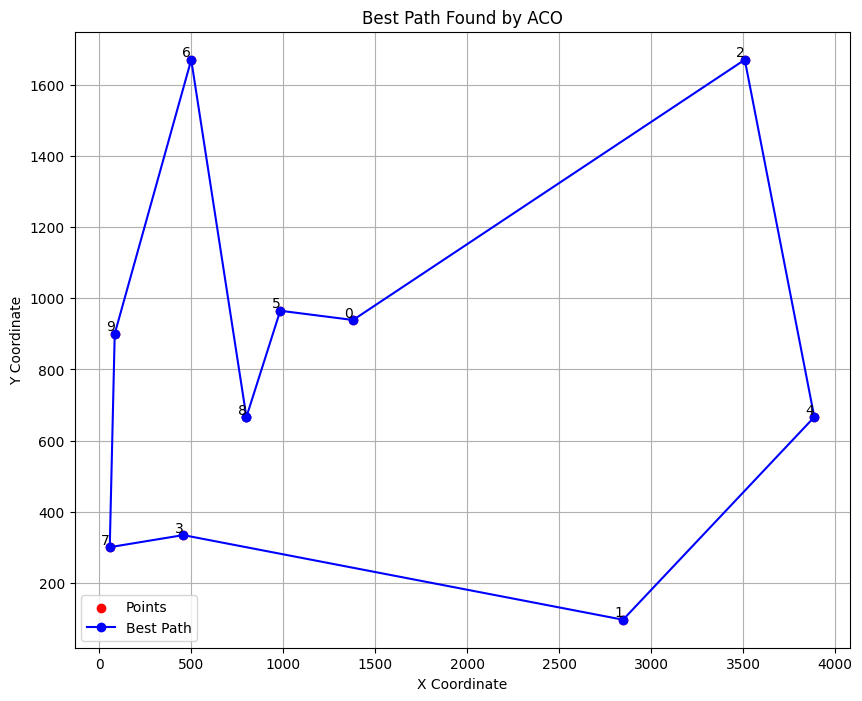

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import time
import warnings

warnings.filterwarnings("ignore")

# Ant Colony Optimizer class (same as in the previous code)
class AntColonyOptimizer:
    def __init__(self, ants, evaporation_rate, intensification, alpha=1.0, beta=0.0, beta_evaporation_rate=0, choose_best=0.1):
        self.ants = ants
        self.evaporation_rate = evaporation_rate
        self.pheromone_intensification = intensification
        self.heuristic_alpha = alpha
        self.heuristic_beta = beta
        self.beta_evaporation_rate = beta_evaporation_rate
        self.choose_best = choose_best

        self.pheromone_matrix = None
        self.heuristic_matrix = None
        self.probability_matrix = None
        self.map = None
        self.set_of_available_nodes = None

        self.best_series = []
        self.best = None
        self.fitted = False
        self.best_path = None
        self.fit_time = None
        self.stopped_early = False

    def _initialize(self):
        num_nodes = self.map.shape[0]
        self.pheromone_matrix = np.ones((num_nodes, num_nodes))
        self.pheromone_matrix[np.eye(num_nodes) == 1] = 0
        self.heuristic_matrix = 1 / self.map
        self.heuristic_matrix[np.isinf(self.heuristic_matrix)] = 0
        self.probability_matrix = (self.pheromone_matrix ** self.heuristic_alpha) * (self.heuristic_matrix ** self.heuristic_beta)
        self.set_of_available_nodes = list(range(num_nodes))

    def _update_probabilities(self):
        self.probability_matrix = (self.pheromone_matrix ** self.heuristic_alpha) * (self.heuristic_matrix ** self.heuristic_beta)

    def _choose_next_node(self, from_node):
        numerator = self.probability_matrix[from_node, self.set_of_available_nodes]
        if np.random.random() < self.choose_best:
            next_node = self.set_of_available_nodes[np.argmax(numerator)]
        else:
            denominator = np.sum(numerator)
            probabilities = numerator / denominator
            next_node = np.random.choice(self.set_of_available_nodes, p=probabilities)
        return next_node

    def _evaporation(self):
        self.pheromone_matrix *= (1 - self.evaporation_rate)
        self.heuristic_beta *= (1 - self.beta_evaporation_rate)

    def _intensify(self, best_coords):
        i, j = best_coords
        self.pheromone_matrix[i, j] += self.pheromone_intensification

    def _evaluate(self, paths, mode):
        scores = []
        path_coords = []
        for path in paths:
            score = sum(self.map[path[i], path[i + 1]] for i in range(len(path) - 1))
            scores.append(score)
            path_coords.append((path[:-1], path[1:]))

        if mode == 'min':
            best_idx = np.argmin(scores)
        else:
            best_idx = np.argmax(scores)
        return path_coords[best_idx], paths[best_idx], scores[best_idx]

    def fit(self, map_matrix, iterations=100, mode='min', early_stopping_count=20, verbose=True):
        self.map = map_matrix
        start_time = time.time()
        self._initialize()

        num_equal = 0
        for iteration in range(iterations):
            paths = []
            for _ in range(self.ants):
                path = []
                current_node = np.random.choice(self.set_of_available_nodes)
                start_node = current_node

                while True:
                    path.append(current_node)
                    self.set_of_available_nodes.remove(current_node)
                    if not self.set_of_available_nodes:
                        break
                    current_node = self._choose_next_node(current_node)

                path.append(start_node)
                paths.append(path)
                self.set_of_available_nodes = list(range(self.map.shape[0]))

            best_coords, best_path, best_score = self._evaluate(paths, mode)
            if verbose:
                print(f"Iteration {iteration}, Best Score: {best_score}")

            if iteration == 0 or (mode == 'min' and best_score < self.best) or (mode == 'max' and best_score > self.best):
                self.best = best_score
                self.best_path = best_path
                num_equal = 0
            else:
                num_equal += 1

            self.best_series.append(self.best)
            self._evaporation()
            self._intensify(best_coords)
            self._update_probabilities()

            if num_equal >= early_stopping_count:
                self.stopped_early = True
                if verbose:
                    print(f"Stopping early after {early_stopping_count} stagnant iterations.")
                break

        self.fitted = True
        self.fit_time = time.time() - start_time
        return self.best

    def plot(self):
        if not self.fitted:
            print("Optimizer has not been fitted yet.")
            return
        plt.plot(self.best_series)
        plt.title("Optimization Progress")
        plt.xlabel("Iteration")
        plt.ylabel("Best Score")
        plt.show()

    def plot_path(self, coordinates):
        if not self.fitted:
            print("Optimizer has not been fitted yet.")
            return

        best_path_coordinates = [coordinates[i] for i in self.best_path]
        x, y = zip(*best_path_coordinates)

        plt.figure(figsize=(10, 8))
        plt.scatter(*zip(*coordinates), c='red', label='Points')
        for i, coord in enumerate(coordinates):
            plt.text(coord[0], coord[1], str(i), fontsize=10, ha='right', va='bottom')

        plt.plot(x, y, linestyle='-', marker='o', color='blue', label='Best Path')
        plt.title("Best Path Found by ACO")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        plt.grid()
        plt.show()

# Execution Example
coordinates = [
    (1380, 939), (2848, 96), (3510, 1671), (457, 334),
    (3888, 666), (984, 965), (500, 1671), (57, 300),
    (800, 666), (84, 900)
]

# Compute the distance matrix
distance_matrix = cdist(coordinates, coordinates)

# Initialize and run ACO
aco = AntColonyOptimizer(
    ants=10, evaporation_rate=0.5, intensification=2,
    alpha=1.0, beta=2.0, choose_best=0.1
)

best_score = aco.fit(distance_matrix, iterations=100, mode='min', early_stopping_count=10, verbose=True)
print(f"Best path score: {best_score}")
print(f"Best path: {aco.best_path}")

# Plot the results
aco.plot()
aco.plot_path(coordinates)